Code adapted from https://github.com/patrickcgray/open-geo-tutorial

In [178]:
from IPython.display import Audio, display
from timeit import default_timer as timer
start = timer()
def alert():
  global start
  end= timer()
  print("\n\nDuration in minutes : " +  str((end - start)/60) + " minutes." )
  display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))

# Preparing Dataset

#### Cutting images for faster process

In [179]:
# 0 to  10980 for this img_data
#training
xmin = 6500
xmax = 7000
ymin = 6600
ymax = 7100
#test
xmin_test = 6000
xmax_test = 6500
ymin_test = 6800
ymax_test = 7300

In [180]:
import rasterio
from rasterio.mask import mask
import geopandas as gp
import numpy as np
import shapely
from shapely import geometry
from shapely.geometry import shape, Point, LineString, Polygon , mapping
import matplotlib.pyplot as plt
from rasterio.plot import show
import pyproj
from pyproj import CRS
import fiona

In [181]:
import os # we need os to do some basic file operations
import re
regexp = re.compile(r'_B0[2348]')
sentinal_20m = "./data/IMG_DATA_1"
# find every file in the sentinal_fp directory
sentinal_band_paths = [os.path.join(sentinal_20m, f) for f in os.listdir(sentinal_20m) if regexp.search(f) ]
sentinal_band_paths.sort()
sentinal_band_paths

['./data/IMG_DATA_1\\T29SMD_20191025T113321_B02.jp2',
 './data/IMG_DATA_1\\T29SMD_20191025T113321_B03.jp2',
 './data/IMG_DATA_1\\T29SMD_20191025T113321_B04.jp2',
 './data/IMG_DATA_1\\T29SMD_20191025T113321_B08.jp2']

In [182]:
for i in sentinal_band_paths : 
        src = rasterio.open(i,driver='JP2OpenJPEG')
        meta = src.meta
        print( i + " ::: ")
        print(meta)


./data/IMG_DATA_1\T29SMD_20191025T113321_B02.jp2 ::: 
{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS.from_epsg(32629), 'transform': Affine(10.0, 0.0, 399960.0,
       0.0, -10.0, 4400040.0)}
./data/IMG_DATA_1\T29SMD_20191025T113321_B03.jp2 ::: 
{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS.from_epsg(32629), 'transform': Affine(10.0, 0.0, 399960.0,
       0.0, -10.0, 4400040.0)}
./data/IMG_DATA_1\T29SMD_20191025T113321_B04.jp2 ::: 
{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS.from_epsg(32629), 'transform': Affine(10.0, 0.0, 399960.0,
       0.0, -10.0, 4400040.0)}
./data/IMG_DATA_1\T29SMD_20191025T113321_B08.jp2 ::: 
{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS.from_epsg(32629), 'transform': Affine(10.0, 0.

In [183]:
# create a products directory within the data dir which won't be uploaded to Github
img_dir = './data/'

# check to see if the dir it exists, if not, create it
if not os.path.exists(img_dir):
    os.makedirs(img_dir)

# filepath for image we're writing out
img_fp = img_dir + 'sentinel_bands_img_data_1.tif'

### Only run this the first time - its slow

In [184]:
"""
# Just run this the first time 
meta = meta
# Update metadata to reflect the number of layers
meta.update(
    count = len(sentinal_band_paths)
)
# Read each layer and write it to stack
with rasterio.open(img_fp, 'w', **meta) as dst:
    for id, layer in enumerate(sentinal_band_paths, start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id, src1.read(1))
"""

"\n# Just run this the first time \nmeta = meta\n# Update metadata to reflect the number of layers\nmeta.update(\n    count = len(sentinal_band_paths)\n)\n# Read each layer and write it to stack\nwith rasterio.open(img_fp, 'w', **meta) as dst:\n    for id, layer in enumerate(sentinal_band_paths, start=1):\n        with rasterio.open(layer) as src1:\n            dst.write_band(id, src1.read(1))\n"

In [185]:
full_dataset = rasterio.open(img_fp)
img_rows, img_cols = full_dataset.shape
img_bands = full_dataset.count
print(full_dataset.shape) # dimensions
print(full_dataset.count) # bands

(10980, 10980)
4


In [186]:
dataset=full_dataset
# what is the name of this image
img_name = dataset.name
print('Image filename: {n}\n'.format(n=img_name))

# How many bands does this image have?
num_bands = dataset.count
print('Number of bands in image: {n}\n'.format(n=num_bands))

# How many rows and columns?
rows, cols = dataset.shape
print('Image size is: {r} rows x {c} columns\n'.format(r=rows, c=cols))

# Does the raster have a description or metadata?
desc = dataset.descriptions
metadata = dataset.meta

print('Raster description: {desc}\n'.format(desc=desc))

# What driver was used to open the raster?
driver = dataset.driver
print('Raster driver: {d}\n'.format(d=driver))

# What is the raster's projection?
proj = dataset.crs
if (not proj) :
    proj = CRS.from_epsg(4326)
print('Image projection:')
print(proj, '\n')

# What is the raster's "geo-transform"
gt = dataset.transform

print('Image geo-transform:\n{gt}\n'.format(gt=gt))

print('All raster metadata:')
print(metadata)
print('\n')

Image filename: ./data/sentinel_bands_img_data_1.tif

Number of bands in image: 4

Image size is: 10980 rows x 10980 columns

Raster description: (None, None, None, None)

Raster driver: JP2OpenJPEG

Image projection:
EPSG:32629 

Image geo-transform:
| 10.00, 0.00, 399960.00|
| 0.00,-10.00, 4400040.00|
| 0.00, 0.00, 1.00|

All raster metadata:
{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 4, 'crs': CRS.from_epsg(32629), 'transform': Affine(10.0, 0.0, 399960.0,
       0.0, -10.0, 4400040.0)}




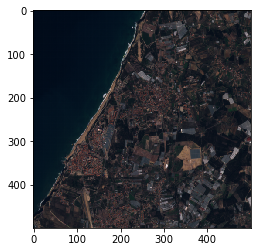

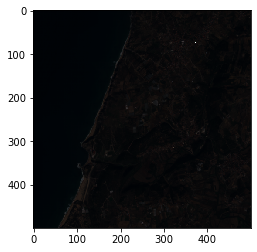

In [187]:
from rasterio.plot import adjust_band
from rasterio.plot import reshape_as_raster, reshape_as_image


cutted = dataset.read([3,2,1])[:,xmin: xmax,ymin : ymax]
rgb_norm = adjust_band(cutted) # normalize bands to range between 1.0 to 0.0
show(rgb_norm)

cutted = dataset.read([3,2,1])[:,xmin_test: xmax_test,ymin_test : ymax_test]
rgb_norm = adjust_band(cutted) # normalize bands to range between 1.0 to 0.0

show(rgb_norm)

In [188]:
import matplotlib.pyplot as plt
from rasterio.plot import show
"""
clipped_img = adjust_band(cutted)
print(clipped_img.shape)
fig, ax = plt.subplots(figsize=(10,7))
show(clipped_img[:,  : , : ], ax=ax, transform=full_dataset.transform) # add the transform arg to get it in lat long coords
"""

'\nclipped_img = adjust_band(cutted)\nprint(clipped_img.shape)\nfig, ax = plt.subplots(figsize=(10,7))\nshow(clipped_img[:,  : , : ], ax=ax, transform=full_dataset.transform) # add the transform arg to get it in lat long coords\n'

# Indices

In [189]:

with rasterio.open(img_fp) as src:
    green_band = src.read(2)[ xmin : xmax ,  ymin : ymax ] # band 3
    red_band = src.read(3)[ xmin : xmax ,  ymin : ymax ]   # band 4
    nir_band = src.read(4)[ xmin : xmax ,  ymin : ymax ]   # band 8
    img = src.read()[:,  xmin : xmax ,  ymin : ymax ]
    
ndwi = (green_band.astype(float) - nir_band.astype(float)) / (green_band.astype(float) + nir_band.astype(float))
ndvi = (nir_band.astype(float) - red_band.astype(float)) / (red_band.astype(float) + nir_band.astype(float))

In [190]:
def color_stretch(image, index):
    colors = image[:, :, index].astype(np.float64)
    for b in range(colors.shape[2]):
        colors[:, :, b] = rasterio.plot.adjust_band(colors[:, :, b])
    return colors

In [191]:
"""
fig, axs = plt.subplots(2,2,figsize=(15,7))

reshaped_img =reshape_as_image( img )
img_stretched = color_stretch(reshaped_img, [2, 1, 0])
axs[0,0].set_title("Stretch")
axs[0,0].imshow(img_stretched)

axs[0,1].set_title("True Color")
axs[0,1].imshow(reshape_as_image(rgb_norm))

nwdi_plot = axs[1,0].imshow(ndwi, cmap="RdYlBu")
axs[1,0].set_title("NDWI")
fig.colorbar(nwdi_plot, ax=axs[1,0])

ndvi_plot = axs[1,1].imshow(ndvi, cmap="RdYlGn")
axs[1,1].set_title("NDVI")
fig.colorbar(ndvi_plot, ax=axs[1,1])

plt.show()
"""

'\nfig, axs = plt.subplots(2,2,figsize=(15,7))\n\nreshaped_img =reshape_as_image( img )\nimg_stretched = color_stretch(reshaped_img, [2, 1, 0])\naxs[0,0].set_title("Stretch")\naxs[0,0].imshow(img_stretched)\n\naxs[0,1].set_title("True Color")\naxs[0,1].imshow(reshape_as_image(rgb_norm))\n\nnwdi_plot = axs[1,0].imshow(ndwi, cmap="RdYlBu")\naxs[1,0].set_title("NDWI")\nfig.colorbar(nwdi_plot, ax=axs[1,0])\n\nndvi_plot = axs[1,1].imshow(ndvi, cmap="RdYlGn")\naxs[1,1].set_title("NDVI")\nfig.colorbar(ndvi_plot, ax=axs[1,1])\n\nplt.show()\n'

In [192]:
src.close()

# Intercepting label data with cutting image

In [193]:
# Open the dataset from the file
shapefile = gp.read_file('./data/shapefiles/shapefile_compressed/shp_2012_IMG_DATA_1.shp')
shapefile = shapefile.filter(['Legenda','geometry','CLC2012'])
shapefile.crs = {'init': 'epsg:4326'}

In [194]:
shapefile

,Legenda,geometry,CLC2012
0,Tecido urbano contínuo,"POLYGON ((-9.27768 38.76588, -9.27746 38.76555...",111
1,Tecido urbano contínuo,"POLYGON ((-9.25850 38.76457, -9.25850 38.76158...",111
2,Tecido urbano contínuo,"POLYGON ((-9.21069 38.76698, -9.21064 38.76633...",111
3,Tecido urbano contínuo,"POLYGON ((-9.22487 38.76998, -9.22474 38.76907...",111
4,Tecido urbano contínuo,"POLYGON ((-9.15237 38.77167, -9.15397 38.77135...",111
...,...,...,...
2606,Planos de água,"POLYGON ((-9.30538 39.32667, -9.30438 39.32591...",512
2607,Planos de água,"POLYGON ((-9.12876 39.36121, -9.12819 39.36034...",512
2608,Lagoas costeiras,"POLYGON ((-9.22812 39.43133, -9.22765 39.43071...",521
2609,Desembocaduras fluviais,"POLYGON ((-8.99046 38.92315, -8.99021 38.92267...",522


In [195]:
shapefile = shapefile.to_crs({'init': 'epsg:32629'})

C:\ProgramData\Anaconda3\envs\geo_py37\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [196]:
shapefile.bounds

,minx,miny,maxx,maxy
0,474782.521060,4.288877e+06,476430.681811,4.290843e+06
1,476591.348965,4.289766e+06,477555.487955,4.290956e+06
2,480560.441620,4.290757e+06,481700.696947,4.291425e+06
3,477478.133322,4.287956e+06,482136.028108,4.291520e+06
4,486477.998487,4.291415e+06,487108.983959,4.292233e+06
...,...,...,...,...
2606,472616.358933,4.352466e+06,474147.798607,4.353889e+06
2607,488111.339739,4.355853e+06,490649.235019,4.357006e+06
2608,479637.064347,4.359617e+06,484220.218501,4.364724e+06
2609,471843.279019,4.272805e+06,507900.408025,4.309807e+06


Img_data_1 cutted

In [197]:
from pyproj import transform
from pyproj import Proj
def cut_bounds( xmin , xmax ,  ymin , ymax ):
    # this will get our four corner points
    xmin = xmin 
    ymin = ymin
    xmax = xmax
    ymax = ymax
    raster_gps_points = full_dataset.transform * (xmin, ymin),full_dataset.transform * (xmax, ymin),full_dataset.transform * (xmax, ymax), full_dataset.transform * (xmin, ymax),
    # Project all longitudes, latitudes using the pyproj package
    p1 = Proj(dataset.crs) # our current crs
    print(p1)
    print('raster bounds in current crs :\n', raster_gps_points)
    return raster_gps_points
raster_gps_points = cut_bounds( xmin , xmax ,  ymin , ymax )
raster_gps_points_test = cut_bounds( xmin_test , xmax_test ,  ymin_test , ymax_test )

Proj('+proj=utm +zone=29 +datum=WGS84 +units=m +no_defs', preserve_units=True)
raster bounds in current crs :
 ((464960.0, 4334040.0), (469960.0, 4334040.0), (469960.0, 4329040.0), (464960.0, 4329040.0))
Proj('+proj=utm +zone=29 +datum=WGS84 +units=m +no_defs', preserve_units=True)
raster bounds in current crs :
 ((459960.0, 4332040.0), (464960.0, 4332040.0), (464960.0, 4327040.0), (459960.0, 4327040.0))


In [198]:
def shapefile_from_rasterbounds(raster_gps_points,shapefile) :
    polygon = Polygon( list(raster_gps_points))
    print("Polygon raster gps points",polygon)
    imageBounds = gp.GeoDataFrame(crs=CRS.from_epsg(32629))
    imageBounds.geometry = [polygon]
    imageBounds = imageBounds.to_crs(fiona.crs.from_epsg(4326))
    print("Imaged cutted bounds",imageBounds.bounds)
    shapefile = shapefile.to_crs(fiona.crs.from_epsg(4326))
    print("Shapefile bounds",shapefile.bounds)
    intersected = gp.sjoin( shapefile, imageBounds, how='inner', op='intersects', lsuffix='left', rsuffix='right')
    intersected = intersected.reset_index()
    print("Intersected df",intersected)
    print("Intersected crs",intersected.crs)
    print("Intersected bounds",intersected.bounds)
    return intersected
intersected = shapefile_from_rasterbounds(raster_gps_points,shapefile)

Polygon raster gps points POLYGON ((464960 4334040, 469960 4334040, 469960 4329040, 464960 4329040, 464960 4334040))
Imaged cutted bounds        minx       miny      maxx       maxy
0 -9.405542  39.109805 -9.347453  39.155046


C:\ProgramData\Anaconda3\envs\geo_py37\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
C:\ProgramData\Anaconda3\envs\geo_py37\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


Shapefile bounds           minx       miny      maxx       maxy
0    -9.290231  38.748262 -9.271269  38.765971
1    -9.269420  38.756289 -9.258351  38.767022
2    -9.223762  38.765308 -9.210637  38.771348
3    -9.259214  38.740093 -9.205557  38.772182
4    -9.155668  38.771354 -9.148402  38.778720
...        ...        ...       ...        ...
2606 -9.317734  39.321207 -9.299920  39.333992
2607 -9.137997  39.352063 -9.108531  39.362436
2608 -9.236594  39.385820 -9.183275  39.431828
2609 -9.323687  38.603732 -8.908901  38.937196
2610 -9.792798  36.730845 -7.206483  41.879798

[2611 rows x 4 columns]
Intersected df     index                                           Legenda  \
0      33                            Tecido urbano contínuo   
1     241                         Tecido urbano descontínuo   
2     247                         Tecido urbano descontínuo   
3     255                         Tecido urbano descontínuo   
4     669                  Culturas temporárias de sequeiro   
5

In [199]:
intersected_test = shapefile_from_rasterbounds(raster_gps_points_test,shapefile)

Polygon raster gps points POLYGON ((459960 4332040, 464960 4332040, 464960 4327040, 459960 4327040, 459960 4332040))
Imaged cutted bounds        minx       miny      maxx       maxy
0 -9.463291  39.091567 -9.405181  39.136837


C:\ProgramData\Anaconda3\envs\geo_py37\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
C:\ProgramData\Anaconda3\envs\geo_py37\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


Shapefile bounds           minx       miny      maxx       maxy
0    -9.290231  38.748262 -9.271269  38.765971
1    -9.269420  38.756289 -9.258351  38.767022
2    -9.223762  38.765308 -9.210637  38.771348
3    -9.259214  38.740093 -9.205557  38.772182
4    -9.155668  38.771354 -9.148402  38.778720
...        ...        ...       ...        ...
2606 -9.317734  39.321207 -9.299920  39.333992
2607 -9.137997  39.352063 -9.108531  39.362436
2608 -9.236594  39.385820 -9.183275  39.431828
2609 -9.323687  38.603732 -8.908901  38.937196
2610 -9.792798  36.730845 -7.206483  41.879798

[2611 rows x 4 columns]
Intersected df    index                                    Legenda  \
0   1122  Sistemas culturais e parcelares complexos   
1   2610                                     Oceano   

                                            geometry  CLC2012  index_right  
0  POLYGON ((-9.38501 39.11545, -9.38499 39.11440...      242            0  
1  POLYGON ((-8.87062 41.81409, -8.87056 41.81326...      5

In [200]:
import re
def class_from_CLCcode(clc) :
    mega_classes = {
        '^1.*' : 'Territórios artificializados',
        '^2.*' : 'Agricultura',
        '^31.*' : 'Floresta',
        '^3.4' : 'Floresta',
        '^32[123]' : 'Vegetação natural',
        '^33[123]' : 'Espaços descobertos ou com vegetação esparsa',
        '^41.*' : 'Zonas húmidas',
        '^42[13]' : 'Zonas húmidas',
        '^5.*' : 'Corpos de água',
        '^422' : 'Corpos de água'
    }
    for mega_class_key in mega_classes :
        searched =  re.search(mega_class_key, str(clc))
        if searched is not None:
            return mega_classes[mega_class_key]
    return 'Not Defined'

x = intersected['CLC2012'][0] 
print (x)
class_from_CLCcode (x) 

111


'Territórios artificializados'

In [201]:
for i in intersected.index:
    clc = intersected.at[i, 'CLC2012']
    new_class = class_from_CLCcode(clc)
    intersected.at[i, 'Mega_Legenda'] = new_class
intersected.head()

,index,Legenda,geometry,CLC2012,index_right,Mega_Legenda
0,33,Tecido urbano contínuo,"POLYGON ((-9.38224 39.13610, -9.38118 39.13594...",111,0,Territórios artificializados
1,241,Tecido urbano descontínuo,"POLYGON ((-9.38625 39.11781, -9.38522 39.11760...",112,0,Territórios artificializados
2,247,Tecido urbano descontínuo,"POLYGON ((-9.35822 39.13399, -9.35783 39.13381...",112,0,Territórios artificializados
3,255,Tecido urbano descontínuo,"POLYGON ((-9.35573 39.14784, -9.35551 39.14782...",112,0,Territórios artificializados
4,669,Culturas temporárias de sequeiro,"POLYGON ((-9.37935 39.11305, -9.37890 39.11288...",211,0,Agricultura


In [202]:
for i in intersected_test.index:
    clc = intersected_test.at[i, 'CLC2012']
    new_class = class_from_CLCcode(clc)
    intersected_test.at[i, 'Mega_Legenda'] = new_class
intersected_test.head()

,index,Legenda,geometry,CLC2012,index_right,Mega_Legenda
0,1122,Sistemas culturais e parcelares complexos,"POLYGON ((-9.38501 39.11545, -9.38499 39.11440...",242,0,Agricultura
1,2610,Oceano,"POLYGON ((-8.87062 41.81409, -8.87056 41.81326...",523,0,Corpos de água


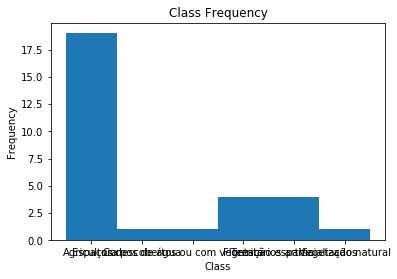

Number of different classes :6
['Agricultura' 'Corpos de água'
 'Espaços descobertos ou com vegetação esparsa' 'Floresta'
 'Territórios artificializados' 'Vegetação natural']


In [203]:
import matplotlib.pyplot as plt
unique, counts = np.unique(intersected['Mega_Legenda'], return_counts=True)
plt.bar(unique, counts, 1)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

print('Number of different classes :'  + str(len(unique)))
print(unique)

# Setting up label data with bands

In [204]:
def setup_shafile_to_data(shapefile,full_dataset) :
    shapefile = shapefile.filter(['Legenda','Mega_Legenda', 'geometry','CLC2012'])
    print("Data crs: " + str(full_dataset.crs))
    print("Before crs: " + str(shapefile.crs))
    if shapefile.crs != {'init': 'epsg:32629'} :
        shapefile = shapefile.to_crs({'init': 'epsg:32629'})
    print("After crs: " + str(shapefile.crs))
    return shapefile
shapefile = setup_shafile_to_data(intersected,full_dataset)
shapefile_test = setup_shafile_to_data(intersected_test,full_dataset)

Data crs: EPSG:32629
Before crs: {'init': 'epsg:4326', 'no_defs': True}


C:\ProgramData\Anaconda3\envs\geo_py37\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


After crs: {'init': 'epsg:32629'}
Data crs: EPSG:32629
Before crs: {'init': 'epsg:4326', 'no_defs': True}


C:\ProgramData\Anaconda3\envs\geo_py37\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


After crs: {'init': 'epsg:32629'}


In [205]:
shapefile.head()

,Legenda,Mega_Legenda,geometry,CLC2012
0,Tecido urbano contínuo,Territórios artificializados,"POLYGON ((466964.424 4331949.479, 467056.111 4...",111
1,Tecido urbano descontínuo,Territórios artificializados,"POLYGON ((466609.165 4329920.686, 466698.172 4...",112
2,Tecido urbano descontínuo,Territórios artificializados,"POLYGON ((469039.730 4331706.460, 469073.026 4...",112
3,Tecido urbano descontínuo,Territórios artificializados,"POLYGON ((469260.812 4333243.314, 469280.171 4...",112
4,Culturas temporárias de sequeiro,Agricultura,"POLYGON ((467203.867 4329390.271, 467242.736 4...",211


Choose target column = Legenda or Mega_Legenda

In [206]:
Class = 'Mega_Legenda'
#Class = 'Legenda' 

In [207]:
unique= np.unique(shapefile[Class])
print('List of Land Cover Classes:')
unique

List of Land Cover Classes:


array(['Agricultura', 'Corpos de água',
       'Espaços descobertos ou com vegetação esparsa', 'Floresta',
       'Territórios artificializados', 'Vegetação natural'], dtype=object)

In [208]:
unique= np.unique(shapefile_test[Class])
print('List of Land Cover Classes for test:')
unique

List of Land Cover Classes for test:


array(['Agricultura', 'Corpos de água'], dtype=object)

In [209]:
#shapefile.geometry = shapefile.geometry.map(lambda polygon: shapely.ops.transform(lambda x, y: (y, x), polygon))

In [210]:
shapefile.bounds

,minx,miny,maxx,maxy
0,466693.388761,4.331197e+06,467687.138734,4.331952e+06
1,465996.598721,4.329296e+06,466917.843856,4.330039e+06
2,466894.548139,4.328722e+06,469242.378114,4.331790e+06
3,466964.423703,4.331532e+06,469737.277794,4.333700e+06
4,466568.437188,4.328411e+06,467826.714693,4.329736e+06
5,468752.564988,4.329424e+06,470697.015567,4.332043e+06
6,467908.277434,4.333156e+06,468642.157173,4.334036e+06
7,469946.590040,4.333078e+06,471644.251313,4.334159e+06
8,468840.714745,4.333654e+06,469671.264515,4.335590e+06
9,467350.703474,4.328203e+06,468052.143352,4.329048e+06


In [211]:
print('raster bounds in current crs :\n', raster_gps_points)

raster bounds in current crs :
 ((464960.0, 4334040.0), (469960.0, 4334040.0), (469960.0, 4329040.0), (464960.0, 4329040.0))


In [212]:
# this generates a list of shapely geometries
geoms = shapefile.geometry.values 
geoms_test = shapefile_test.geometry.values 

# let's grab a single shapely geometry to check
geometry = geoms[0] 
print(type(geometry))
print(geometry)

# transform to GeoJSON format
from shapely.geometry import mapping
feature = [mapping(geometry)] # can also do this using polygon.__geo_interface__
print(type(feature))
print(feature)

<class 'shapely.geometry.polygon.Polygon'>
POLYGON ((466964.4237027746 4331949.479068073, 467056.111145639 4331931.712223588, 467149.0952492154 4331951.234501887, 467195.676337795 4331951.679405843, 467233.3416034218 4331910.11235441, 467266.3709926478 4331866.171847544, 467332.0516111786 4331817.884539855, 467369.6945313095 4331778.64652798, 467372.3127682726 4331748.391088762, 467391.6125745543 4331678.697532657, 467454.6972043611 4331658.336574916, 467550.6555184731 4331610.338493205, 467611.8873344366 4331536.322760579, 467595.4293370568 4331424.44890151, 467638.0257973998 4331385.875851696, 467670.3637442201 4331322.715065499, 467687.1387342545 4331227.671187854, 467672.6153339227 4331197.917508592, 467650.105950683 4331196.678844143, 467572.913497621 4331230.880677446, 467456.3941267077 4331236.755756233, 467405.0214429033 4331250.24069206, 467309.4857897328 4331253.986883694, 467197.7358053764 4331248.261140807, 467150.9991210354 4331264.119713548, 467120.4323009839 4331294.1082

In [213]:
out_image, out_transform = rasterio.mask.mask(full_dataset, feature,crop=True)
out_image.shape

(4, 77, 100)

In [214]:
out_transform

Affine(10.0, 0.0, 466690.0,
       0.0, -10.0, 4331960.0)

In [218]:
def setup_features_and_target(src,geoms,shapefile) : 
    X = np.array([], dtype=np.int8).reshape(0,4) # pixels for training
    y = np.array([], dtype=np.string_) # labels for training
    # extract the raster values within the polygon 
    band_count = src.count
    for index, geom in enumerate(geoms):
        feature = [mapping(geom)]

        # the mask function returns an array of the raster pixels within this feature
        out_image, out_transform = rasterio.mask.mask(src, feature,crop=True)
        # eliminate all the pixels with 0 values for all 8 bands - AKA not actually part of the shapefile
        out_image_trimmed = out_image[:,~np.all(out_image == 0, axis=0)]
        # eliminate all the pixels with 255 values for all 8 bands - AKA not actually part of the shapefile
        out_image_trimmed = out_image_trimmed[:,~np.all(out_image_trimmed == 255, axis=0)]
        # reshape the array to [pixel count, bands]
        out_image_reshaped = out_image_trimmed.reshape(-1, band_count)
        # append the labels to the y array
        y = np.append(y,[shapefile[Class][index]] * out_image_reshaped.shape[0]) 
        # stack the pizels onto the pixel array
        X = np.vstack((X,out_image_reshaped))
    return X,y

In [219]:
src = full_dataset
X,y = setup_features_and_target(src,geoms,shapefile)
X_test,y_test = setup_features_and_target(src,geoms_test,shapefile_test)

In [220]:
# What are our classification labels?
labels = np.unique(shapefile[Class])
print('The training data include {n} classes: {classes}\n'.format(n=labels.size, 
                                                                classes=labels))
labels_test = np.unique(shapefile_test[Class])
print('The testing data include {n} classes: {classes}\n'.format(n=labels_test.size, 
                                                                classes=labels_test))

# We will need a "X" matrix containing our features, and a "y" array containing our labels
print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))

print('Our X_test matrix is sized: {sz}'.format(sz=X_test.shape))
print('Our y_test array is sized: {sz}'.format(sz=y_test.shape))


The training data include 6 classes: ['Agricultura' 'Corpos de água'
 'Espaços descobertos ou com vegetação esparsa' 'Floresta'
 'Territórios artificializados' 'Vegetação natural']

The training data include 2 classes: ['Agricultura' 'Corpos de água']

Our X matrix is sized: (35129396, 4)
Our y array is sized: (35129396,)
Our X_test matrix is sized: (33224143, 4)
Our y_test array is sized: (33224143,)


Text(0.5, 1.0, 'Band Intensities Higher Ref Subset')

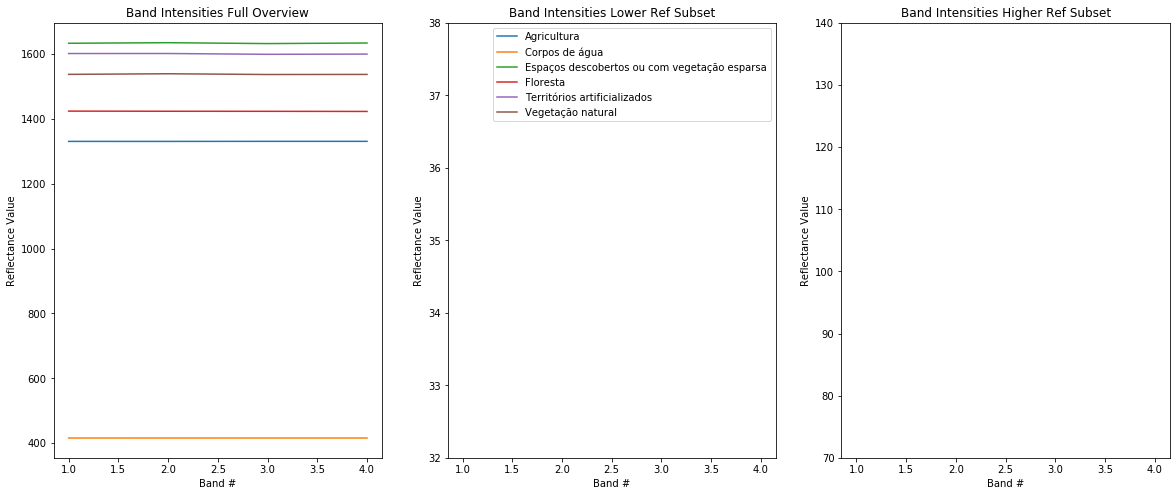

In [221]:
fig, ax = plt.subplots(1,3, figsize=[20,8])

# numbers 1-4
band_count = np.arange(1,5)

classes = np.unique(y)
for class_type in classes:
    band_intensity = np.mean(X[y==class_type, :], axis=0)
    ax[0].plot(band_count, band_intensity, label=class_type)
    ax[1].plot(band_count, band_intensity, label=class_type)
    ax[2].plot(band_count, band_intensity, label=class_type)
# plot them as lines

# Add some axis labels
ax[0].set_xlabel('Band #')
ax[0].set_ylabel('Reflectance Value')
ax[1].set_ylabel('Reflectance Value')
ax[1].set_xlabel('Band #')
ax[2].set_ylabel('Reflectance Value')
ax[2].set_xlabel('Band #')
#ax[0].set_ylim(32,38)
ax[1].set_ylim(32,38)
ax[2].set_ylim(70,140)
#ax.set
ax[1].legend(loc="upper right")
# Add a title
ax[0].set_title('Band Intensities Full Overview')
ax[1].set_title('Band Intensities Lower Ref Subset')
ax[2].set_title('Band Intensities Higher Ref Subset')

In [222]:
def str_class_to_int(class_array):
    class_array[class_array == 'Territórios artificializados'] = 0
    class_array[class_array == 'Agricultura'] = 1
    class_array[class_array == 'Floresta'] = 2
    class_array[class_array == 'Vegetação natural'] = 3
    class_array[class_array == 'Espaços descobertos ou com vegetação esparsa'] = 4
    class_array[class_array == 'Zonas húmidas'] = 5
    class_array[class_array == 'Corpos de água'] = 6
    return(class_array.astype(int))
def str_class_to_int_v2(class_array,class_test):
    uniques = np.unique(class_array)
    i=0
    for class_name in uniques :
        class_array[class_array == class_name ] = i
        class_test[class_test == class_name ] = i
        i+=1
    return(class_array.astype(int) , class_test.astype(int) ) 

In [223]:
print(np.unique(y))
print(np.unique(y_test))
y = str_class_to_int(y)
y_test = str_class_to_int(y_test)
print(np.unique(y))
print(np.unique(y_test))


['Agricultura' 'Corpos de água'
 'Espaços descobertos ou com vegetação esparsa' 'Floresta'
 'Territórios artificializados' 'Vegetação natural']
['Agricultura' 'Corpos de água']
[0 1 2 3 4 6]
[1 6]


# Supervised Classification Algorithm

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
#model = LinearSVC(C=1,verbose=1)
model = KNeighborsClassifier()
model.fit(X, y)
score = model.score(X_test, y_test)
score

In [ ]:
with rasterio.open(img_fp) as src:
    # may need to reduce this image size if your kernel crashes, takes a lot of memory
    img = src.read()[:, xmin_test : xmax_test ,  ymin_test : ymax_test ]

# Take our full image and reshape into long 2d array (nrow * ncol, nband) for classification
print(img.shape)
reshaped_img = reshape_as_image(img)
print(reshaped_img.shape)

In [ ]:
class_prediction = model.predict(reshaped_img.reshape(-1, 4))
before = class_prediction.shape
# Reshape our classification map back into a 2D matrix so we can visualize it
class_prediction = class_prediction.reshape(reshaped_img[:, :, 0].shape)
class_prediction.shape

In [ ]:
"""
reshaped_img.reshape(-1, 4).shape
real_img = y_test[:250000] #fixme
print(before)
print(real_img.shape)
print(y_test.shape)
# Reshape our classification map back into a 2D matrix so we can visualize it
real_class = real_img.reshape(reshaped_img[:, :, 0].shape) #fixme
real_class.shape
"""

In [ ]:
real_class = real_class.astype(int)
print(real_class)
class_prediction = class_prediction.astype(int)
class_prediction

# Visualizing results 

In [ ]:
    
# find the highest pixel value in the prediction image
n = int(np.max(class_prediction))

# next setup a colormap for our map
colors = dict((
    (0, (60, 60, 60, 255)),     # Grey - Territórios artificializados
    (1, (20,230,20, 255)),      # Light Green - Agricultura
    (2, (5, 80, 5, 255)),       # Dark Green - Floresta
    (3, (170, 200, 20, 255)),   # Yellow - Vegetação natural
    (4, (50, 20, 0, 255)),      # Brown - Espaços descobertos ou com vegetação esparsa
    (5, (0, 250, 250, 255)),    # Light Blue - Zonas húmidas
    (6, (0, 0, 200, 255)),      # Dark Blue - Corpos de água
))

# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(0, n+1)]

cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n+1)

In [ ]:
def discrete_matshow(data):
    #get discrete colormap
    cmap = plt.get_cmap('RdBu', np.max(data)-np.min(data)+1)
    # set limits .5 outside true range
    mat = plt.matshow(data,cmap=cmap,vmin = np.min(data)-.5, vmax = np.max(data)+.5)
    #tell the colorbar to tick at integers
    cax = plt.colorbar(mat, ticks=np.arange(np.min(data),np.max(data)+1))

In [ ]:

fig, axs = plt.subplots(1,2,figsize=(20,20))

img_stretched = color_stretch(reshaped_img, [2, 1, 0])
axs[0].imshow(img_stretched)

prediction_plot= axs[1].imshow(class_prediction, cmap=cmap, interpolation='none')
fig.colorbar(prediction_plot, ax=axs[1],ticks=range(0,6),fraction=0.046, pad=0.04)

#real_plot = axs[2].imshow(real_class, cmap=cmap, interpolation='none')
#fig.colorbar(real_plot, ax=axs[2],ticks=range(0,6),fraction=0.046, pad=0.04)

fig.show()

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15,15))

img_stretched = color_stretch(reshaped_img, [2, 1, 0])

axs[0].imshow(img_stretched[0:100, 0:100])

prediction_plot = axs[1].imshow(class_prediction[0:100, 0:100], cmap=cmap, interpolation='none')
fig.colorbar(prediction_plot, ax=axs[1],ticks=range(0,4),fraction=0.046, pad=0.04)

fig.show()

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,7))

reshaped_img =reshape_as_image( img )
img_stretched = color_stretch(reshaped_img, [2, 1, 0])
axs[0,0].set_title("True Color")
axs[0,0].imshow(img_stretched)

axs[0,1].set_title("Class Prediction")
predictions_plot = axs[0,1].imshow(class_prediction, cmap=cmap, interpolation='none')
fig.colorbar(predictions_plot, ax=axs[0,1],ticks=range(0,6))

nwdi_plot = axs[1,0].imshow(ndwi, cmap="RdYlBu")
axs[1,0].set_title("NDWI")
fig.colorbar(nwdi_plot, ax=axs[1,0])

ndvi_plot = axs[1,1].imshow(ndvi, cmap="RdYlGn")
axs[1,1].set_title("NDVI")
fig.colorbar(ndvi_plot, ax=axs[1,1])

plt.show()

In [ ]:
alert() # audio alert